In [1]:
### run the script from the figures_code directory

import sys
sys.path.insert(0,'../')
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import general_functions as gf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## (C) - TF dependency on GRFs

/home/labs/barkailab/tamarj/.conda/envs/trial_env/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/labs/barkailab/tamarj/.conda/envs/trial_env/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/labs/barkailab/tamarj/.conda/envs/trial_env/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/labs/barkailab/tamarj/.conda/envs/trial_env/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/labs/barkailab/tamarj/.conda/envs/trial_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _metho

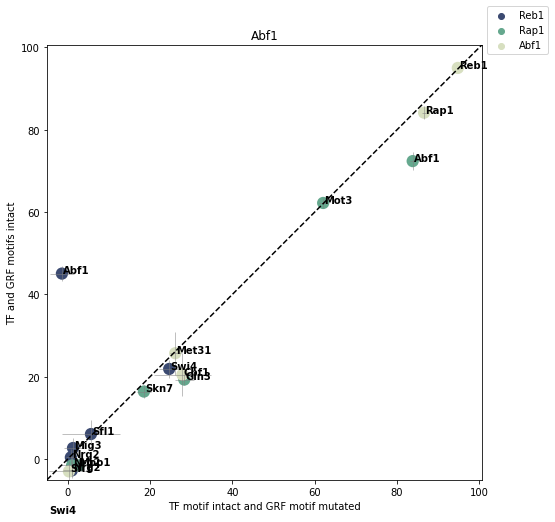

In [2]:
dir_path = dir_path = '/home/labs/barkailab/tamarj/TF_combinatorics/'
grfs = ['Reb1', 'Rap1', 'Abf1']
tp='180'
thresh=0
col_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
col_names = ['TF_wt_GRF_wt', 'TF_wt_GRF_mut','TF_wt_GRF_wt_sem', 'TF_wt_GRF_mut_sem', 'TF', 'GRF', 'Library', 'Library_number']
tfs_grf_df = pd.DataFrame(columns=col_names)   

for grf in grfs: # iterate over GRFs
    tf_files = dp.find_tf_files(grf) # get GRf files
    for file in tf_files: # iterate over files
        _, lib_num, exp_num = file.split('.')[0].split('_') # get library and experiment numbers
        if exp_num=='26': # skip experiment 26
            continue
        grf_pos = lto.get_tf_mot_pos(grf, lib_num) #get grf positions
        norm_df = lto.norm_res_data(grf, lib_num, exp_num, norm_to=0, occ=None) # normlize data - tp0 only
        lib_info = dp.get_lib_info(lib_num)  # get library info
        lib_name = lib_info['gene'] # gene names
        wt_pos = np.array(lib_info['wt_at_var_loc']) # get wt positions
        mut_pos = np.array(list(lto.get_mut_var(lib_num))) # get mutated positions
        # get indices of sequences containing the GRF motifs intact/mutatated
        lib_files = dp.find_lib_files(lib_num) # get all library files
        for tf_file in lib_files: # iterate over library files
            tf, _, tf_exp_num = tf_file.split('.')[0].split('_') # get file tf and experiment number
            if (tf==grf) or (tf_exp_num=='26'): # skip experiment 26
                continue
            tf_norm_df = dp.mean_over_bio_reps(lto.norm_res_data(tf, lib_num, tf_exp_num, norm_to=0, occ=None))  # normlize data - tp0 only
            norm_df_by_tp = tf_norm_df.iloc[:,np.where(tf_norm_df.columns.str.contains(tp))[0][0]] #get only the relevant time point
            lib_seqs = list(norm_df_by_tp.index)
            grf_wt_ids, grf_mut_ids, _, _, _, _ = lto.get_all_tf_motifs_wt_or_mut(grf,lib_info, lib_seqs) 
            tf_pos = lto.get_tf_mot_pos(tf, lib_num) #get tf positions
            tf_pos_wt_ids, _, _, _, _, _ = lto.get_all_tf_motifs_wt_or_mut(tf,lib_info, lib_seqs) # get ids containing the tf positions intact

            
            tf_wt_grf_wt_ids = np.intersect1d(grf_wt_ids,tf_pos_wt_ids) # get ids in which: GRF positions are wt & TF positions are wt
            tf_wt_grf_mut_ids = np.intersect1d(grf_mut_ids,tf_pos_wt_ids)# get ids in which: GRF positions are mut & TF positions are wt
            tf_wt_grf_wt_seqs = np.array(lib_seqs)[tf_wt_grf_wt_ids]
            tf_wt_grf_mut_seqs = np.array(lib_seqs)[tf_wt_grf_mut_ids]

            relevant_pos = np.concatenate([grf_pos, tf_pos])
            norm_seqs_ids_grf_wt = []
            norm_seqs_ids_grf_mut = []
            for seq in tf_wt_grf_wt_seqs:
                temp_seq = np.repeat('x', len(mut_pos))
                temp_seq[np.delete(np.arange(0,len(wt_pos)),relevant_pos)] = np.array(list(seq))[np.delete(np.arange(0,len(wt_pos)),relevant_pos)]
                temp_seq[relevant_pos] = mut_pos[relevant_pos]
                seq_to_norm = ''.join(temp_seq)
                norm_seqs_ids_grf_wt.append(lib_seqs.index(seq_to_norm))

            for seq in tf_wt_grf_mut_seqs:
                temp_seq = np.repeat('x', len(mut_pos))
                temp_seq[np.delete(np.arange(0,len(wt_pos)),relevant_pos)] = np.array(list(seq))[np.delete(np.arange(0,len(wt_pos)),relevant_pos)]
                temp_seq[relevant_pos] = mut_pos[relevant_pos]
                seq_to_norm = ''.join(temp_seq)
                norm_seqs_ids_grf_mut.append(lib_seqs.index(seq_to_norm))

            tf_wt_grf_wt_mean = np.mean(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_wt_ids].values - norm_df_by_tp[norm_seqs_ids_grf_wt].values) *100)
            tf_wt_grf_mut_mean = np.mean(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_mut_ids].values - norm_df_by_tp[norm_seqs_ids_grf_mut].values) *100)
            tf_wt_grf_wt_sem = scipy.stats.sem(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_wt_ids].values - norm_df_by_tp[norm_seqs_ids_grf_wt].values) *100)
            tf_wt_grf_mut_sem = scipy.stats.sem(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_mut_ids].values - norm_df_by_tp[norm_seqs_ids_grf_mut].values) *100)            
            tfs_grf_df.loc[len(tfs_grf_df.index)] = [tf_wt_grf_wt_mean, tf_wt_grf_mut_mean,tf_wt_grf_wt_sem,
                                                     tf_wt_grf_mut_sem, tf, grf, lib_name, int(lib_num)]
            
lib_color_dict = gf.generate_color_dict(sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=False), np.unique(grfs), 2)

fig,ax = plt.subplots(1,1,figsize=(10,8))

tfs_grf_df.dropna(inplace=True)

for grf_i, grf in enumerate(grfs):
    df_by_grf = tfs_grf_df.loc[tfs_grf_df['GRF']==grf]
    sns.scatterplot(data=df_by_grf, x='TF_wt_GRF_mut', y='TF_wt_GRF_wt', palette=lib_color_dict, hue='GRF', edgecolor="none", s=150, ax=ax) 
    ax.errorbar(df_by_grf['TF_wt_GRF_mut'], df_by_grf['TF_wt_GRF_wt'], xerr=df_by_grf['TF_wt_GRF_mut_sem'], 
                yerr=df_by_grf['TF_wt_GRF_wt_sem'], ecolor='grey',elinewidth=0.5, color='none', fmt='o')
    
    for i in range(len(df_by_grf)):
        line = df_by_grf.iloc[i,:]    
        plt.text(line['TF_wt_GRF_mut']+0.2,line['TF_wt_GRF_wt'], line['TF'], horizontalalignment='left', size='medium', color='black', weight='semibold')

minimum = np.min((ax.get_xlim(),ax.get_ylim()))
maximum = np.max((ax.get_xlim(),ax.get_ylim()))
ax.set_xlim(-5,maximum)
ax.set_ylim(-5,maximum)
ax.set_title(grf)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
ax.set_xlabel('TF motif intact and GRF motif mutated')
ax.set_ylabel('TF and GRF motifs intact')
plt.axline((0,0),slope=1, c='k', linestyle='--')

for t, l in zip(ax.legend_.texts,grfs):
    t.set_text(l)

ax.set_aspect('equal', 'box')


## (E) GRFs cooperativity scores

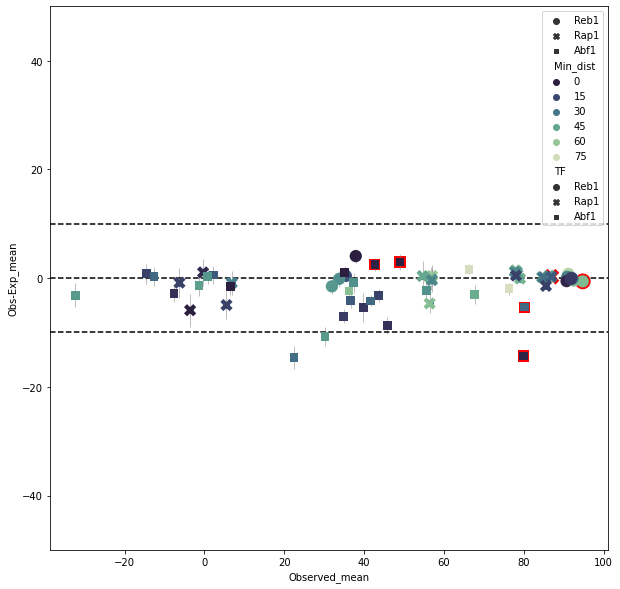

In [3]:
tfs = ['Reb1', 'Rap1', 'Abf1']
exp_nums = ['16','16', '26']
tps = ['180', '180', '210']
col_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
col_map_r = matplotlib.colors.ListedColormap(col_map.colors[::-1])

all_tf_mean_df = pd.DataFrame()
for tf_i, tf in enumerate(tfs):
    tf_libs = np.unique([file.split('_')[1] for file in dp.find_tf_files(tf)])
    for lib_num in tf_libs:
        curr_tf_df = lto.obs_exp_mean_context(tf, lib_num, tps[tf_i], [tf], exp_num=exp_nums[tf_i])
        all_tf_mean_df = pd.concat([all_tf_mean_df, curr_tf_df])

fig,ax = plt.subplots(figsize=(10,10))

self_df = all_tf_mean_df.query("Comb_type=='Self_comb'")
sns.scatterplot(data=self_df, x='Observed_mean', y='Obs-Exp_mean', color='r',style='TF', s=250, linewidth=0, ax=ax)


sns.scatterplot(data=all_tf_mean_df, x='Observed_mean', y='Obs-Exp_mean', hue='Min_dist', palette=col_map_r, linewidth=0, style='TF', s=150, zorder=20, ax=ax)
plt.errorbar(all_tf_mean_df['Observed_mean'], all_tf_mean_df['Obs-Exp_mean'], yerr=all_tf_mean_df['Obs-Exp_sem'],ecolor='grey',elinewidth=0.5, fmt='o')

ax.set_ylim(-50,50)
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')


## (C) Specific examples - Abf1 inhibition, Reb1 no interactions

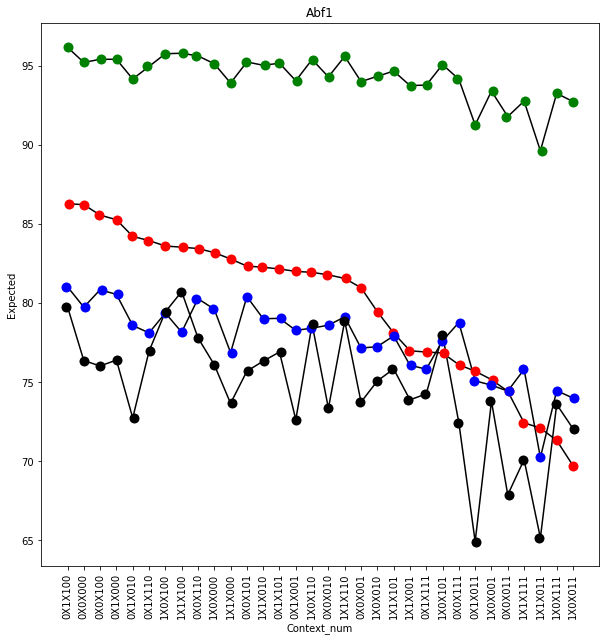

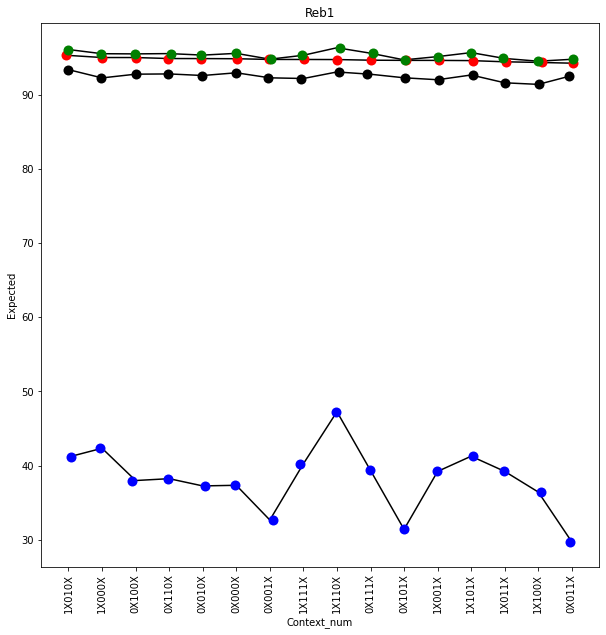

In [4]:
from importlib import reload
reload(lto)

grfs = ['Abf1', 'Reb1']
libs = ['81', '76']
exps = ['26', '16']
combs = [[1,3], [1,5]]
tps = ['210', '180'] 

for grf_i, grf in enumerate(grfs):
    
    lib_num = libs[grf_i]
    exp = exps[grf_i]
    comb = combs[grf_i]
    tp = tps[grf_i]
    
    comb_df = lto.comb_opts_by_context(grf,lib_num,exp, comb, tp)
    
    comb_df_norm = comb_df.iloc[:,0:3] - comb_df.iloc[:,3].to_frame().values
    comb_df_norm['Context'] = comb_df['Context'] 
    comb_df = comb_df_norm
    
    
    comb_df_expected = comb_df.copy()
    comb_df_rel =  comb_df[['++','+-','-+']]
    comb_df_rel = lto.convert_fc_to_occ(comb_df_rel)
    comb_df_rel['Expected'] = 1-((1-comb_df_rel['+-'])*(1-comb_df_rel['-+']))
    comb_df_rel = comb_df_rel*100

    lib_info = dp.get_lib_info(lib_num)
    wt_var_seq = lib_info['wt_at_var_loc']  # get wild-type sequence
    context_nums = []
    for seq in comb_df['Context'].values:
        seq = list(seq)
        seq.insert(comb[0], 'X')
        seq.insert(comb[1], 'X')
        seq = np.array(seq)
        for i,nuc in enumerate(seq):
            if nuc == wt_var_seq[i]:
                seq[i] = '1'
            elif nuc == 'X':
                continue
            else:
                seq[i] = '0'

        context_nums.append(''.join(seq))
    comb_df_rel['Context_num'] = context_nums

    opts_dots = ['++', '+-', '-+','Expected']

    comb_df_rel.sort_values(by='++', ascending=False, inplace=True)
    cols = ['r','b','k','g']
    comb_df_rel.sort_values(by='++')
    comb_df_rel.reset_index(drop=True, inplace=True)
    figure, ax = plt.subplots(1,1,figsize=(10,10))
    axes = []
    for i, opt in enumerate(opts_dots):
        curr_ax = sns.stripplot(data=comb_df_rel, x='Context_num', y=opt, color=cols[i],s=10, ax=ax)
        sns.lineplot(data=comb_df_rel, x=comb_df_rel.index, y=opt, color='k', ax=ax)
        axes.append(curr_ax)
    plt.xticks(rotation = 90)
    ax.set_title(grf)
